# Data Analysis for Santa Clara Master Gardener Club by Michelle Petersen

## Overview

Since 1981, the University of California Master Gardener Program has been extending UC research-based information about home horticulture and pest management to the public. The UC Master Gardener Program is a public service and outreach program under the University of California Division of Agriculture and Natural Resources, administered locally by participating UC Cooperative Extension county offices.

The UC Master Gardener Program is an example of an effective partnership between the University of California and passionate volunteers. In exchange for training from the University, UC Master Gardeners offer volunteer services and outreach to the general public in more than 50 California counties. Last year 6,116 active UC Master Gardener volunteers donated 398,265 hours, and 5.4+ million hours have been donated since the program's inception.

Volunteers complete a 16-week, 60+ hour training program in home horticulture and remain certified on a yearly basis.

The Master Gardeners of Santa Clara have begun using the Nextdoor App to increase local community outreach. Each week the assigned Master Gardener for a neighborhood will send tips of the week and answer questions. The Nextdoor App is opt-in. Each household must sign up with the app and verify thier identity. The number of residences that are members of Nextdoor is hidden except to a logged in member or to the neighborhood leaders. The Nextdoor platform allows members to communicate with their neighborhood and nearby neighborhoods only. This goal is to provide a sense of connectedness among members.

Questions to be Answered by this analysis:
* What are all the Nextdoor neighborhoods in Santa Clara County?
* Which Neighborhoods are reached by each Master Gardener?
* Which Neighborhoods do not have a Master Gardener assigned or are not able to be reached?
* What is the interest level in gardening for each Nextdoor Neighborhood?

In [55]:
# Imports
%matplotlib inline
import pandas as pd
import numpy as np
import json
import geojson
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

## Gather

#### Read Master Gardener Contacts and Nextdoor Neighborhood Information from Google Doc Spreadsheet

In [2]:
import gspread
from google.oauth2 import service_account
from google.auth.transport.requests import AuthorizedSession

# The scope to read the spreadsheet
_GS_SCOPE = ['https://www.googleapis.com/auth/spreadsheets.readonly',
            'https://www.googleapis.com/auth/drive']

# The ID and range of the MasterGardener spreadsheet.
_GS_ID = '1pPOuRZ9YsKwXGKgxzSm9tXCR_dgkCY4WNh3rg_cFX08'

service_account_info = json.load(open('Master Gardener-7e906e507d9d.json'))
credentials = service_account.Credentials.from_service_account_info(
    service_account_info,
    scopes=_GS_SCOPE)

if credentials:
    gc = gspread.Client(auth=credentials)
    gc.session = AuthorizedSession(credentials)
    book = gc.open_by_key(_GS_ID)
    print(book.title)
    worksheet_list = book.worksheets()
    for worksheet in worksheet_list:
        print(worksheet)

Santa Clara County Master Gardeners
<Worksheet 'Contacts' id:0>
<Worksheet 'Contact - Neighborhod Mapping' id:1690020129>
<Worksheet 'Nextdoor Neighborhoods' id:354027930>


In [3]:
# Load the data from each sheet into a dataframe
df_contacts = pd.DataFrame(book.get_worksheet(0).get_all_values())
df_contact_neighborhood = pd.DataFrame(book.get_worksheet(1).get_all_values())
df_nextdoor_neighborhoods = pd.DataFrame(book.get_worksheet(2).get_all_values())

In [4]:
# Update the column names for the contact worksheet
df_contacts.reset_index()
df_contacts.columns = ['Name', 'Email', 'Neighborhood', 'State', 'County', 'City']

In [5]:
# Remove the row with column names since gspread reads it as data
df_contacts = df_contacts[df_contacts['Name'] != 'Name']

In [ ]:
# Verify column names and data
df_contacts.head()

In [7]:
# Update the column names for the contact to neighborhood mapping worksheet
df_contact_neighborhood.reset_index()
df_contact_neighborhood.columns = ['Name', 'Neighborhood', 'State', 'County', 'City']

In [8]:
# Remove the row with column names since gspread reads it as data
df_contact_neighborhood = df_contact_neighborhood[df_contact_neighborhood['Name'] != 'Name']

In [ ]:
# Verify column names and data
df_contact_neighborhood.head()

In [12]:
# Update the column names for the nextdoor neighborhood worksheet
df_nextdoor_neighborhoods.reset_index()
df_nextdoor_neighborhoods.columns = ['State', 'County', 'City', 'Neighborhood', 'Link', 'Nextdoor ID', 
                                     'Geometry', 'Interests', 'Interest in Gardening', 'Percentage of Homeowners', 
                                     'Number of Residents', 'Average Age', 'Attributes']

In [13]:
# Remove the row with column names since gspread reads it as data
df_nextdoor_neighborhoods = df_nextdoor_neighborhoods[df_nextdoor_neighborhoods['Neighborhood'] != 'Neighborhood']

In [16]:
# Update columns to numeric data types
df_nextdoor_neighborhoods[["Nextdoor ID", "Interest in Gardening", "Percentage of Homeowners", "Number of Residents", "Average Age"]] = df_nextdoor_neighborhoods[["Nextdoor ID", "Interest in Gardening", "Percentage of Homeowners", "Number of Residents", "Average Age"]].apply(pd.to_numeric)

In [17]:
# Verify column names and data
df_nextdoor_neighborhoods.head()

,State,County,City,Neighborhood,Link,Nextdoor ID,Geometry,Interests,Interest in Gardening,Percentage of Homeowners,Number of Residents,Average Age,Attributes
1,CA,Santa Clara,Gilroy,1st St.,https://nextdoor.com/neighborhood/1stst--gilro...,389933,"{""type"": ""Feature"", ""geometry"": {""type"": ""Mult...","['SF Giants', 'Golden State Warriors', 'Hiking...",10,0,0,0,"['Bay', 'Community', 'Diversity', 'Dog Friendl..."
2,CA,Santa Clara,Sunnyvale,37 Degrees North,https://nextdoor.com/neighborhood/37degreesnor...,235506,"{""type"": ""Feature"", ""geometry"": {""type"": ""Mult...","['Biking & Cycling', 'Hiking & Trails', 'Cooki...",10,69,1715,47,"['Clean', 'Freeway Access', 'Peaceful', 'Well ..."
3,CA,Santa Clara,Gilroy,3rd Street,https://nextdoor.com/neighborhood/3rdstreetgil...,350380,"{""type"": ""Feature"", ""geometry"": {""type"": ""Mult...","['Dogs', 'Wine Tasting', 'Seeing Live Music', ...",5,0,0,0,"['Peaceful', 'Safe', 'Quiet', 'Clean', 'Family..."
4,CA,Santa Clara,Santa Clara,49ers-Backdoor-Community,https://nextdoor.com/neighborhood/49ersbackdoo...,197902,"{""type"": ""Feature"", ""geometry"": {""type"": ""Mult...","['Hiking & Trails', 'Walking', 'Home Improveme...",3,81,3006,46,"[""Well Maintained"", ""Clean"", ""Safe"", ""Walkabil..."
5,CA,Santa Clara,Saratoga,4th Street,https://nextdoor.com/neighborhood/4thstreetsar...,198597,"{""type"": ""Feature"", ""geometry"": {""type"": ""Mult...","['Walking', 'Hiking & Trails', 'Biking & Cycli...",4,66,679,48,"['Events', 'Food', 'Parks', 'Restaurants', 'Sc..."


In [18]:
# Verify neighborhood columns and data
df_nextdoor_neighborhoods.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1027 entries, 1 to 1027
Data columns (total 13 columns):
State                       1027 non-null object
County                      1027 non-null object
City                        1027 non-null object
Neighborhood                1027 non-null object
Link                        1027 non-null object
Nextdoor ID                 1027 non-null int64
Geometry                    1027 non-null object
Interests                   1027 non-null object
Interest in Gardening       1027 non-null int64
Percentage of Homeowners    1027 non-null int64
Number of Residents         1027 non-null int64
Average Age                 1027 non-null int64
Attributes                  1027 non-null object
dtypes: int64(5), object(8)
memory usage: 112.3+ KB


In [19]:
# Gather attribute data from neighborhoods
df_attributes = pd.read_csv("nextdoor_attributes_master.csv")

In [20]:
# Gather interest data from neighborhoods
df_interests = pd.read_csv("nextdoor_interests_master.csv")

## Store

In [21]:
# Resave neighborhood information to csv files for input to Tableau
df_nextdoor_neighborhoods.to_csv('nextdoor_with_properties_master.csv', index=False)

In [22]:
# Resave information to csv files for input to Tableau
df_contacts.to_csv('mg_contacts_master.csv', index=False)
df_contact_neighborhood.to_csv('mg_contact_neighborhood_master.csv', index=False)

In [27]:
# Save geographic information to geojson file for input to Tableau
from geojson import Point, Feature, FeatureCollection, dumps

features = []
for index, row in df_nextdoor_neighborhoods.iterrows():
    if (len(row["Geometry"]) > 0):
        features.append(json.loads(row["Geometry"]))

feature_collection = FeatureCollection(features)

with open('nextdoor_neighborhoods.geojson', 'w') as f:
   geojson.dump(feature_collection, f)

## Add Attributes for Visualization 

In [46]:
df_nextdoor_neighborhoods["Level of Gardening Interest"] = "Other"

In [48]:
def label_interest(row):
    if row['Interest in Gardening'] == 10:
        return 'None'
    if row['Interest in Gardening'] >= 0 and row['Interest in Gardening'] < 3:
        return 'High'
    if row['Interest in Gardening'] >= 3 and row['Interest in Gardening'] < 8:
        return 'Medium'
    if row['Interest in Gardening'] >= 8 and row['Interest in Gardening'] < 10:
        return 'Low'
    return 'Other'

In [49]:
df_nextdoor_neighborhoods['Level of Gardening Interest'] = df_nextdoor_neighborhoods.apply (lambda row: label_interest (row),axis=1)

## Analysis and Visualization

### Analysis 1: Neighborhood Interests and Attributes

#### Number of Unique Neighborhood Interests

In [388]:
df_interests["Interest"].nunique()

158

#### Top 10 Interests

In [362]:
df_interests["Interest"].value_counts().nlargest(10)

Hiking & Trails           904
Walking                   876
Cooking                   839
Home Improvement & DIY    765
Dogs                      750
Gardening & Landscape     722
Seeing Live Music         591
Books                     556
Volunteering              518
Biking & Cycling          501
Name: Interest, dtype: int64

#### Number of Unique Neighborhood Attributes

In [389]:
df_attributes["Attribute"].nunique()

80

#### Top 10 Attributes

In [361]:
df_attributes["Attribute"].value_counts().nlargest(10)

Family Friendly    694
Peaceful           675
Friendly           598
Clean              546
Dog Friendly       500
Quiet              487
Neighbors          462
Safe               455
Beautiful          414
Walkability        398
Name: Attribute, dtype: int64

### Analysis 2: Descriptive Statistics

In [435]:
df_nextdoor_neighborhoods.describe()

,Nextdoor ID,Interest in Gardening,Percentage of Homeowners,Number of Residents,Average Age,Interest in Cycling
count,1027.000000,1027.000000,1027.000000,1027.000000,1027.000000,1027.000000
mean,197889.446933,5.941577,60.799416,2647.576436,45.721519,8.646543
std,91670.136795,10.074309,28.420757,2727.503741,16.299833,9.525113
min,822.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,167299.500000,2.000000,45.000000,809.000000,46.000000,6.000000
50%,179718.000000,4.000000,69.000000,1888.000000,50.000000,10.000000
75%,244652.000000,10.000000,83.000000,3633.500000,54.000000,10.000000
max,471965.000000,100.000000,98.000000,20571.000000,69.000000,100.000000


### Analysis 2: Correlation

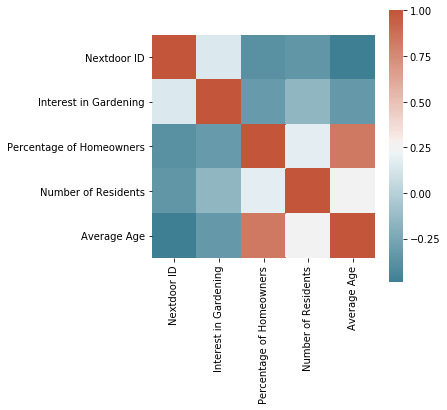

In [30]:
f, ax = plt.subplots(figsize=(5, 5))
corr = df_nextdoor_neighborhoods.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 20, as_cmap=True),
            square=True, ax=ax)

### Visualization 1: Univariate Plot of Average Age

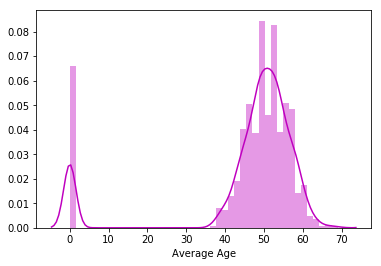

In [440]:
# Plot a historgram and kernel density estimate for Average Age
sns.distplot(df_nextdoor_neighborhoods["Average Age"], color="m")

### Visualization 2: Univariate Plot of Percentage of Homeowners

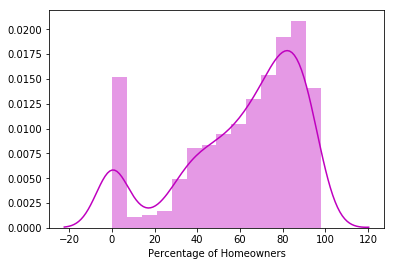

In [441]:
# Plot a historgram and kernel density estimate for Percentage of Homeowners
sns.distplot(df_nextdoor_neighborhoods["Percentage of Homeowners"], color="m")

### Visualization 3: Univariate Plot of Number of Residents

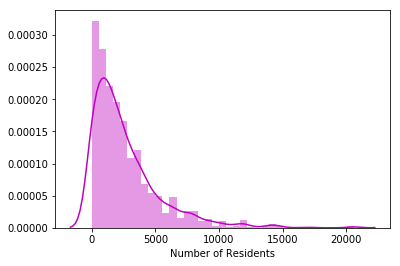

In [443]:
# Plot a historgram and kernel density estimate for Number of Residents
sns.distplot(df_nextdoor_neighborhoods["Number of Residents"], color="m")

### Visualization 4: Univariate Plot for Interest in Gardening
* Interest in Gardening is determined by the stack rank of `Gardening and Landscaping` by residents of a neighborhood.  Rank 10 means there was no interest in `Gardening and Landscaping` for that neighborhood.

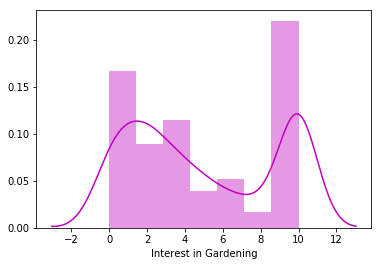

In [34]:
# Plot a historgram and kernel density estimate for Interest in Gardening
df_plot = df_nextdoor_neighborhoods.loc[df_nextdoor_neighborhoods["Interest in Gardening"] != 100]
sns.distplot(df_plot["Interest in Gardening"], color="m")

### Visualization 5: Univariate Plot for Neighborhoods with an Interest in Gardening 

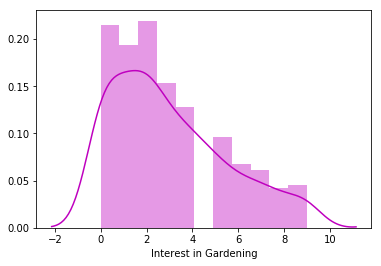

In [33]:
# Plot a historgram and kernel density estimate for Interest in Gardening
df_plot = df_plot.loc[df_plot["Interest in Gardening"] != 10]
sns.distplot(df_plot["Interest in Gardening"], color="m")

### Analysis 3: Descriptive Statistics of Neighborhoods with an Interest in Gardening

In [512]:
df_plot.describe()

,Nextdoor ID,Interest in Gardening,Percentage of Homeowners,Number of Residents,Average Age,Interest in Cycling
count,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000
mean,183065.138122,3.000000,67.455801,3088.755525,48.875691,7.969613
std,86445.832726,2.514137,24.694302,2852.271537,13.275296,2.737813
min,822.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,164624.750000,1.000000,55.000000,1112.000000,48.000000,6.000000
50%,172876.000000,2.000000,74.000000,2311.500000,52.000000,10.000000
75%,214783.000000,5.000000,86.000000,4069.500000,55.000000,10.000000
max,470322.000000,9.000000,98.000000,20571.000000,69.000000,10.000000


### Visualization 6: Bivariate Plot for Interest in Gardening and Age vs Homeownership

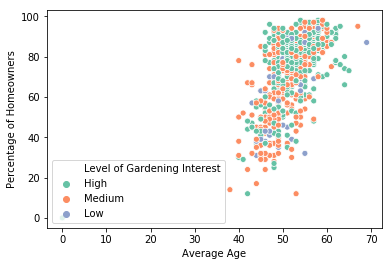

In [52]:
# Scatter plot for Interest in Gardening and Age and Homeownership
df_gardening = df_nextdoor_neighborhoods.loc[(df_nextdoor_neighborhoods["Level of Gardening Interest"] != 'Other') 
                                             & (df_nextdoor_neighborhoods["Level of Gardening Interest"] != 'None')]
interest_ranking = ["High", "Medium", "Low"]
sns.scatterplot(x="Average Age", y="Percentage of Homeowners", data=df_gardening, 
               hue='Level of Gardening Interest', legend="full", palette="Set2",
               hue_order=interest_ranking)
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower left')

### Analysis 3: Descriptive Statistics of Neighborhoods with a `High` Interest in Gardening

In [53]:
df_high = df_nextdoor_neighborhoods.loc[df_nextdoor_neighborhoods["Level of Gardening Interest"] == "High"]
df_high.describe()

,Nextdoor ID,Interest in Gardening,Percentage of Homeowners,Number of Residents,Average Age
count,372.000000,372.000000,372.000000,372.000000,372.000000
mean,188608.932796,1.008065,71.575269,2932.220430,49.771505
std,84272.832723,0.832260,23.780493,2456.178282,13.269097
min,1127.000000,0.000000,0.000000,0.000000,0.000000
25%,164784.500000,0.000000,64.750000,1172.000000,49.000000
50%,174517.000000,1.000000,78.000000,2337.500000,52.000000
75%,218581.500000,2.000000,88.000000,3863.250000,56.000000
max,460423.000000,2.000000,98.000000,13870.000000,65.000000


## Conclusions

Please see [this Tableau Story](https://public.tableau.com/profile/mpetersen000#!/vizhome/SantaClaraCountyMasterGardeners/SantaClaraMasterGardener?publish=yes) for additional visualizations for the Santa Clara Master Gardeners answering their questions:

* What are all the Nextdoor neighborhoods in Santa Clara County?
* Which Neighborhoods are being reached by each Master Gardener?
* Which Neighborhoods do not have a Master Gardener assigned or are not able to be reached?
* What is the interest level in gardening for each Neighborhood?